In [1]:
import json
import glob
import matplotlib.pylab as plt
import numpy as np
from scipy.special import erf
import sys
sys.path.append('./../figures/')
from makeCorner import *

Load `.json` results file which contains
1. direct output from `emcee` interference, without any processing
2. post-processed output from `emcee` inference

In [2]:
name = "component_spin_betaSpikePlusTruncatedMixture"
with open(f'{name}.json', 'r') as f:
    data = json.load(f)

The contents of this file are the following:

| Parameter (dict key) | Description |
| :-------- | :---------- |
| `mu_chi` | Mean of the spin magnitude beta distribution|
| `sigma_chi` | Standard deviation of the spin magnitude beta distribution |
| `MF_cost` | Mixing fraction in aligned spin subpopulation forthe  $\cos\theta$ distribution |
| `sigma_cost` |  Standard deviation of the  aligned spin subpopulation for the $\cos\theta$ distribution |
| `frac_in_spike` |  Mixing fraction in half gaussian spike at $\chi = 0$ |
| `sigma_spike` | Standard deviation of the half gaussian spike at $\chi = 0$  |
| `cost_min` | Minimum cutoff for the $\cos\theta$ distribution |
| `Bq` | Power-law index on the conditional secondary mass distribution $p(m_2 | m_1)$|

Next, plot our various chains to inspect convergence:

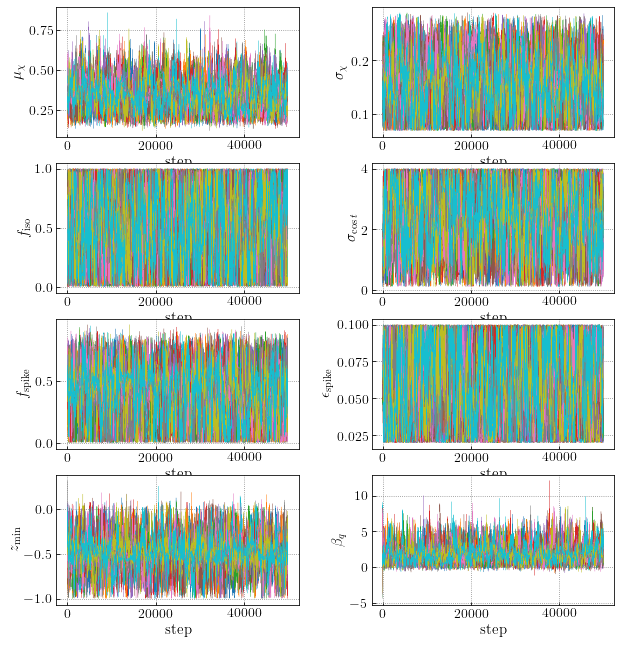

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,11))

# mu_chi
for chain in data['mu_chi']['unprocessed']:
    axes[0][0].plot(chain, lw=0.25)
axes[0][0].set_ylabel(r'$\mu_\chi$', fontsize=15)

# sigma_chi
for chain in data['sigma_chi']['unprocessed']:
    axes[0][1].plot(chain, lw=0.25)
axes[0][1].set_ylabel(r'$\sigma_\chi$', fontsize=15)

# mixing fraction cos(theta) 
for chain in data['MF_cost']['unprocessed']:
    axes[1][0].plot(1-np.asarray(chain), lw=0.25)
axes[1][0].set_ylabel(r'$f_\mathrm{iso}$', fontsize=15)

# sigma_cos(theta)
for chain in data['sigma_cost']['unprocessed']:
    axes[1][1].plot(chain, lw=0.25)
axes[1][1].set_ylabel(r'$\sigma_{\cos t}$', fontsize=15)

# f_spike
for chain in data['frac_in_spike']['unprocessed']:
    axes[2][0].plot(chain, lw=0.25)
axes[2][0].set_ylabel(r'$f_\mathrm{spike}$', fontsize=15)

# sigma_spike
for chain in data['sigma_spike']['unprocessed']:
    axes[2][1].plot(chain, lw=0.25)
axes[2][1].set_ylabel(r'$\epsilon_\mathrm{spike}$', fontsize=15)

# min cos(theta)
for chain in data['cost_min']['unprocessed']:
    axes[3][0].plot(chain, lw=0.25)
axes[3][0].set_ylabel(r'$z_\mathrm{min}$', fontsize=15)

# beta_q
for chain in data['Bq']['unprocessed']:
    axes[3][1].plot(chain, lw=0.25)
axes[3][1].set_ylabel(r'$\beta_{q}$', fontsize=15)

for ax in axes: 
    for a in ax:
        a.set_xlabel('step', fontsize=15)       

plt.subplots_adjust(wspace=0.3)
plt.show()

Let's make a corner plot showing posteriors on our parameters:

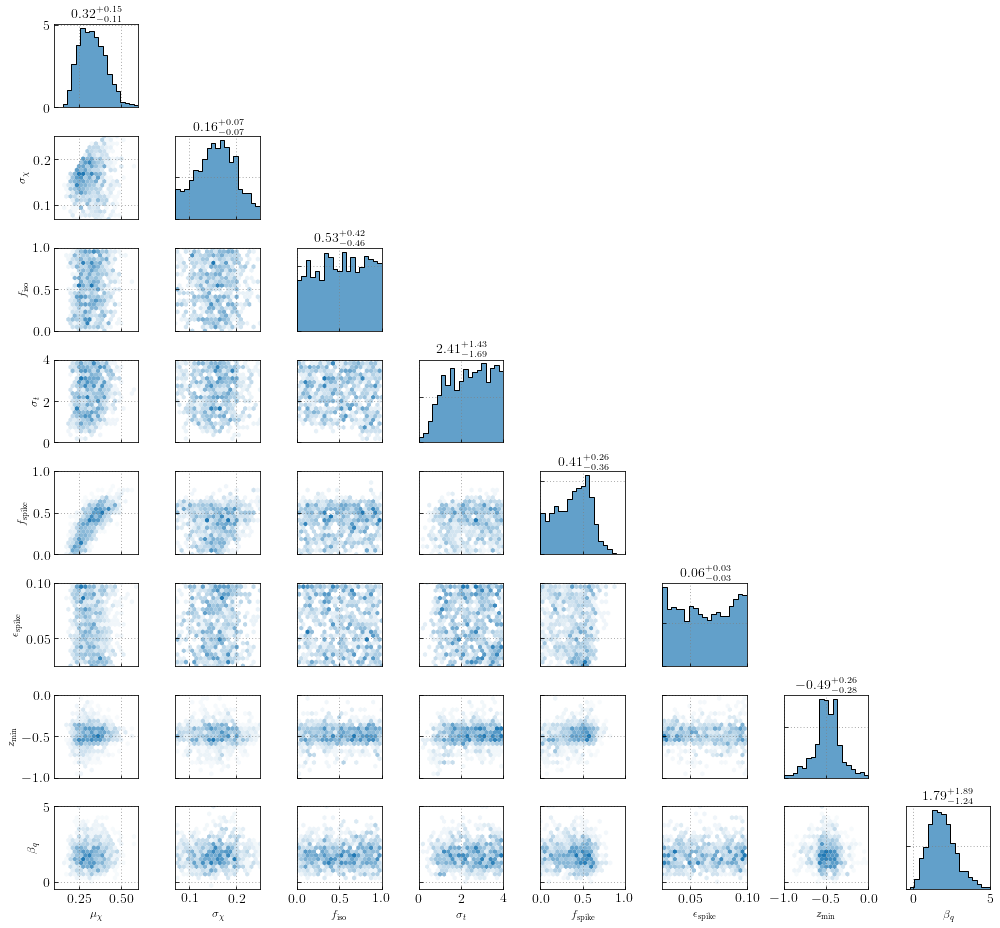

In [3]:
eps_min = 0.025
condition = (np.asarray(data['sigma_spike']['processed'])>eps_min)

fig = plt.figure(figsize=(14,13))

toPlot = {
    "mu_chi":{"data":np.asarray(data['mu_chi']['processed'])[condition], "plot_bounds":(0.1,0.6), "label":r"$\mu_\chi$"},
    "sigma_chi":{"data":np.asarray(data['sigma_chi']['processed'])[condition], "plot_bounds":(0.07,0.25), "label":r"$\sigma_\chi$" },
    "MF_cost":{"data":1-np.asarray(data['MF_cost']['processed'])[condition], "plot_bounds":(0,1), "label":r"$f_\mathrm{iso}$" },
    "sigma_cost":{"data":np.asarray(data['sigma_cost']['processed'])[condition], "plot_bounds":(0,4), "label":r"$\sigma_t$" }, 
    "frac_in_spike":{"data":np.asarray(data['frac_in_spike']['processed'])[condition], "plot_bounds":(0,1), "label":r"$f_\mathrm{spike}$" }, 
    "sigma_spike":{"data":np.asarray(data['sigma_spike']['processed'])[condition], "plot_bounds":(eps_min,0.1), "label":r"$\epsilon_\mathrm{spike}$" }, 
    "cost_min":{"data":np.asarray(data['cost_min']['processed'])[condition], "plot_bounds":(-1,0), "label":r"$z_\mathrm{min}$" }, 
    "Bq":{"data":np.asarray(data['Bq']['processed'])[condition], "plot_bounds":(-0.5,5), "label":r"$\beta_q$" },
}

plot_corner(fig,toPlot,'#1f78b4',labelsize=12)
plt.tight_layout()
plt.show()

Finally, let's make a "trace plot" showing the set of $\chi$ and $\cos \theta$ distributions corresponding to the above samples:

In [9]:
sys.path.append('./../code/emceeCode')
from posterior_helper_functions import calculate_Gaussian_Mixture_1D, mu_sigma2_to_a_b, betaDistributionPlusSpike

In [10]:
# Define a grid of effective spins
chi_grid = np.linspace(0,1,1000)
cost_grid = np.linspace(-1,1,1000)

# Choose a number of traces to draw
nTraces = 1000

# Instantiate an array to hold a collection of traces
p_chi = np.zeros((nTraces,chi_grid.size))
p_cost = np.zeros((nTraces,cost_grid.size))

# For a random set of posterior samples, compute and store the corresponding probability densities across our grid
random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
for i,ind in enumerate(random_indices):
    
    mu_chi = data['mu_chi']['processed'][ind]
    sigma_chi = data['sigma_chi']['processed'][ind]
    MF_cost = data['MF_cost']['processed'][ind]
    sigma_cost = data['sigma_cost']['processed'][ind]
    f_spike = data['frac_in_spike']['processed'][ind]
    sigma_spike = data['sigma_spike']['processed'][ind]
    cost_min = data['cost_min']['processed'][ind]
    
    # calculate beta distribution for chi
    a, b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
    p_chi[i,:] = betaDistributionPlusSpike(chi_grid, a, b, f_spike, sigma_spike)
    
    # and gaussian + mixture for cos(theta)
    p_cost[i,:] = calculate_Gaussian_Mixture_1D(cost_grid, 1, sigma_cost, MF_cost, cost_min, 1)

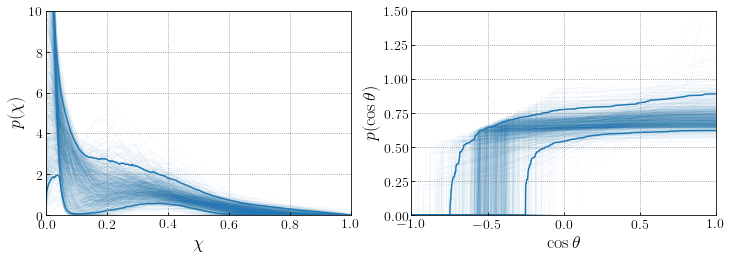

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3.75))

# Plot individual traces
axes[0].plot(chi_grid, p_chi.T,color='#1f78b4', lw=0.15, alpha=0.15, zorder=0)
axes[1].plot(cost_grid, p_cost.T,color='#1f78b4', lw=0.15, alpha=0.15, zorder=0)

# Also plot 5% and 95% credible bounds
axes[0].plot(chi_grid,np.quantile(p_chi,0.05,axis=0),color='#1f78b4',zorder=1)
axes[0].plot(chi_grid,np.quantile(p_chi,0.95,axis=0),color='#1f78b4',zorder=1)
axes[1].plot(cost_grid,np.quantile(p_cost,0.05,axis=0),color='#1f78b4',zorder=1)
axes[1].plot(cost_grid,np.quantile(p_cost,0.95,axis=0),color='#1f78b4',zorder=1)

axes[0].set_xlim(0,1)
axes[0].set_ylim(0,10)
axes[0].set_xlabel(r'$\chi$',fontsize=18)
axes[0].set_ylabel(r'$p(\chi)$',fontsize=18)

axes[1].set_xlim(-1,1)
axes[1].set_ylim(0,1.5)
axes[1].set_xlabel(r'$\cos \theta$',fontsize=18)
axes[1].set_ylabel(r'$p(\cos \theta)$',fontsize=18)

plt.show()